<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/SIMULACI%C3%93_A/Energiaperpanell_angle%C3%B2ptim_nombre%C3%B2ptimdepanells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Energia anual per panell (kWh/any): 830.7149563142849


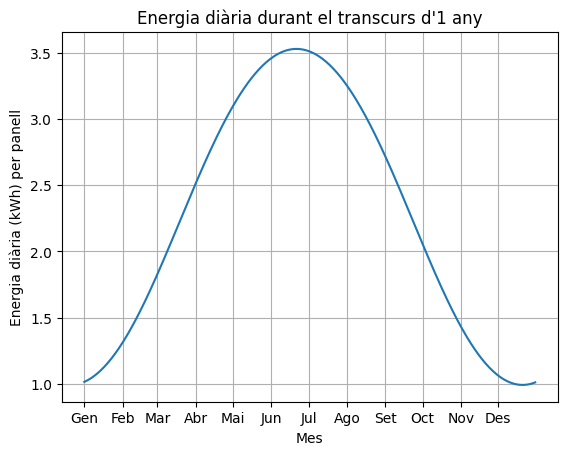

Energia anual per panell (kWh/any): 830.7149563142849
Panells òptims per cobrir l'objectiu: 4.213238215342596


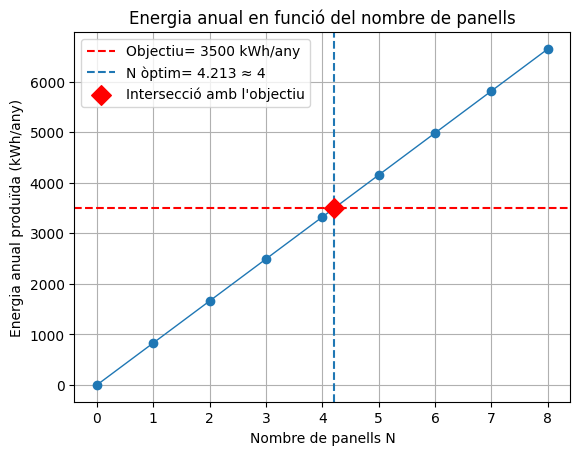

Alpha òptim (inclinació)= 41.6°
Energia anual màxima per panell= 1071.5 kWh/any


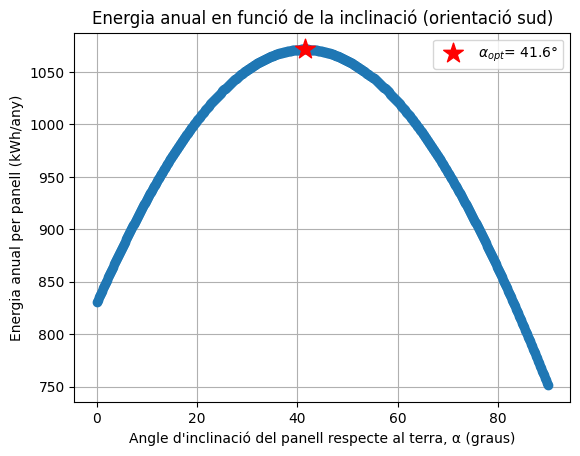

In [1]:
import numpy as np
import matplotlib.pyplot as plt

latitud= 41.50320 * np.pi / 180   # Latitud Bellaterra en radians
area_panell= 2  # m^2
pot_max= 400    # Energia elèctrica generada per panell (W)
irr_ref= 1000   # Irradiància a la qual es genera energia_max (W/m^2)
objectiu_kWh_any= 3500 # Consum anual mitjà d'una casa (kWh/any), el farem servir com a objectiu

# Discretització temporal (un dia)
periode_dia= 24 * 3600
dt= 60 # (s)
omega= 2 * np.pi / periode_dia


# RK4 AIXÒ SERÀ SUBSTITUIT PEL QUE TROBEM DE DINÀMICA PLANETÀRIA %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
eix_rotacio= np.array([0.0, 0.0, 1.0])

def derivada_vector(t, v):
    return omega * np.cross(eix_rotacio, v)

def pas_rk4(derivada, t, v, dt):
    k1= derivada(t, v)
    k2= derivada(t + 0.5*dt, v + 0.5*dt*k1)
    k3= derivada(t + 0.5*dt, v + 0.5*dt*k2)
    k4= derivada(t + dt,     v + dt*k3)
    return v + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Normal local inicial (tria meridià y=0)
# Vector radial a latitud: [cos(latitud), 0, sin(latitud)]
normal_inicial= np.array([np.cos(latitud), 0.0, np.sin(latitud)])

# Precalcula n(t) per un dia
temps_dia= np.zeros(int(periode_dia/dt) + 1)
normal_dia= np.zeros((int(periode_dia/dt) + 1, 3))

t= 0.0
v= normal_inicial.copy()

for i in range(int(periode_dia/dt) + 1):
    normal_dia[i]= v / np.linalg.norm(v)
    temps_dia[i]= t
    if i < int(periode_dia/dt):
        v= pas_rk4(derivada_vector, t, v, dt)
        v= v / np.linalg.norm(v)   # renormalitza
        t += dt


# Model solar anual: declinació delta(dia) i direcció del Sol s(delta)
# s es fixa durant el dia i només canvia amb el dia de l'any
def declinacio_solar(dia_any):
    # dia_any= 1..365 (aprox clàssica)
    return 23.44 * np.pi / 180* np.sin(2*np.pi*(dia_any - 81)/365.0)

def direccio_sol_unitaria(delta):
    # Direcció del Sol en el sistema inertial:
    # al migdia solar estaria al pla x-z; fem servir s= [cosδ, 0, sinδ]
    s= np.array([np.cos(delta), 0.0, np.sin(delta)])
    return s / np.linalg.norm(s)

# AQUÍ ACABA LA PART DE DINÀMICA PLANETÀRIA %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


def energia_anual_per_panell_kWh():
    energia_any_J= 0.0
    energia_diaria_kWh= np.zeros(365)

    for dia_any in range(1, 366):
        delta= declinacio_solar(dia_any)
        sol_unit= direccio_sol_unitaria(delta)

        # cos(alpha)= n·s (panell horitzontal => normal= n)
        cos_alpha= np.dot(normal_dia, sol_unit)
        cos_alpha= np.maximum(0.0, cos_alpha)   # de nit o darrere el cosinus donaria negatiu així que amb aquesta linia passem a que doni 0

        irr_perp= irr_ref * cos_alpha           # W/m^2
        pot= pot_max * (irr_perp / irr_ref)     # escala lineal
        pot= np.minimum(pot, pot_max)           # saturació a 400 W

        energia_dia_J= np.sum(pot) * dt
        energia_any_J += energia_dia_J
        energia_diaria_kWh[dia_any - 1]= energia_dia_J / 3.6e6

    return energia_any_J / 3.6e6, energia_diaria_kWh

energia_panell_any_kWh, energia_diaria_kWh= energia_anual_per_panell_kWh()

print("Energia anual per panell (kWh/any):", energia_panell_any_kWh)

# Gràfic energia diària al llarg de l'any
plt.figure()
dies_any= np.arange(1, 366)
plt.plot(dies_any, energia_diaria_kWh)

inicis_mes= np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
noms_mes= ["Gen", "Feb", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Oct", "Nov", "Des"]
plt.xticks(inicis_mes, noms_mes)

plt.xlabel("Mes")
plt.ylabel("Energia diària (kWh) per panell")
plt.title("Energia diària durant el transcurs d'1 any")
plt.grid(True)
plt.show()


# Nombre òptim de panells
N_optim= objectiu_kWh_any / energia_panell_any_kWh
N_optim_enter= int(N_optim)

print("Energia anual per panell (kWh/any):", energia_panell_any_kWh)
print("Panells òptims per cobrir l'objectiu:", N_optim)

# Energia anual en funció del nombre de panells
max_panells_plot= int(max(6, 2 * N_optim))
n_panells= np.arange(0, max_panells_plot + 1)

energia_total_kWh= n_panells * energia_panell_any_kWh

plt.figure()
plt.plot(n_panells, energia_total_kWh, marker='o', linewidth=1)
plt.axhline(objectiu_kWh_any, linestyle='--', color="red", label=f"Objectiu= {objectiu_kWh_any:.0f} kWh/any")
plt.axvline(N_optim, linestyle='--', label=f"N òptim= {N_optim:.3f} ≈ {N_optim_enter}")
plt.scatter([N_optim], [N_optim * energia_panell_any_kWh], marker='D', color='red', s=100, label="Intersecció amb l'objectiu", zorder=5)
plt.xlabel("Nombre de panells N")
plt.ylabel("Energia anual produïda (kWh/any)")
plt.title("Energia anual en funció del nombre de panells")
plt.grid(True)
plt.legend()
plt.show()





energia_total_kWh= n_panells * energia_panell_any_kWh

# Energia ANUAL EN FUNCIÓ DE LA INCLINACIÓ DEL PANELL (alpha)
# alpha= 0° horitzontal, alpha= 90° vertical
# Triem panell orientat cap al SUD (azimut sud) per maximitzar

z_tilde= np.array([0.0, 0.0, 1.0])

def sud_local_unitari(n_unit):
    # Projecta -z_tilde sobre el pla perpendicular a n_unit (pla horitzontal local)
    u= -z_tilde - np.dot(-z_tilde, n_unit) * n_unit
    norma= np.linalg.norm(u)
    if norma < 1e-12:
        # Cas límit (pol): qualsevol direcció horitzontal serveix
        return np.array([0.0, 1.0, 0.0])
    return u / norma

# Precalcula sud(t) per a tot el dia
sud_dia= np.zeros_like(normal_dia)
for i in range(normal_dia.shape[0]):
    sud_dia[i]= sud_local_unitari(normal_dia[i])

def energia_anual_per_panell_inclinacio(alpha_rad):
    energia_any_J= 0.0
    n_panell_dia= (np.cos(alpha_rad) * normal_dia) + (np.sin(alpha_rad) * sud_dia)
    # Normalitzem
    normes= np.linalg.norm(n_panell_dia, axis=1)
    n_panell_dia= n_panell_dia / normes[:, None]

    for dia_any in range(1, 366):
        delta= declinacio_solar(dia_any)
        sol_unit= direccio_sol_unitaria(delta)

        cos_inc= np.dot(n_panell_dia, sol_unit)
        cos_inc= np.maximum(0.0, cos_inc)

        irr_perp= irr_ref * cos_inc
        pot= pot_max * (irr_perp / irr_ref)
        pot= np.minimum(pot, pot_max)

        energia_dia_J= np.sum(pot) * dt
        energia_any_J += energia_dia_J

    return energia_any_J / 3.6e6  # kWh/any

# Possibles angles d'inclinació respecte al terra (alpha) amb orientació sud
pas_alpha= 0.2
alphas_graus= np.arange(0.0, 90.0 + pas_alpha, pas_alpha)
alphas_rad= alphas_graus * np.pi / 180

energia_any_alpha= np.array([energia_anual_per_panell_inclinacio(a) for a in alphas_rad])

# Alpha òptim (màxim)
idx_max= np.argmax(energia_any_alpha)
alpha_optim_graus= alphas_graus[idx_max]
energia_max_kWh_any= energia_any_alpha[idx_max]

print(f"Alpha òptim (inclinació)= {alpha_optim_graus:.1f}°")
print(f"Energia anual màxima per panell= {energia_max_kWh_any:.1f} kWh/any")

# Gràfica
plt.figure()
plt.plot(alphas_graus, energia_any_alpha, marker='o', linewidth=1)
plt.scatter([alpha_optim_graus], [energia_max_kWh_any], marker='*', color='red', s=220, label=fr"$\alpha_{{opt}}$= {alpha_optim_graus:.1f}°", zorder=5)
plt.xlabel("Angle d'inclinació del panell respecte al terra, α (graus)")
plt.ylabel("Energia anual per panell (kWh/any)")
plt.title("Energia anual en funció de la inclinació (orientació sud)")
plt.grid(True)
plt.legend()
plt.show()